Приступим к попытками улучшить качество нашей модели. Для начала подтянем бейзлайн и попробуем добавить колонку с наличием каких-нибудь однозначно классифицируемых эмодзи.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

In [3]:
data = pd.read_csv("wb_reviews.csv")

data

,Name,Description,Review,Rating
0,Мочалка для душа Grizzly XXL для тела черная,Готовы к незабываемым впечатлениям в душе? «Gr...,Хорошо моет,10
1,Мочалка для душа Grizzly XXL для тела черная,Готовы к незабываемым впечатлениям в душе? «Gr...,"При первом использовании заметил ,что мочалка ...",2
2,Мочалка для душа Grizzly XXL для тела черная,Готовы к незабываемым впечатлениям в душе? «Gr...,Супер всё!,10
3,Мочалка для душа Grizzly XXL для тела черная,Готовы к незабываемым впечатлениям в душе? «Gr...,"Пошита, на первый взгляд, не плохо. Мылится не...",10
4,Мочалка для душа Grizzly XXL для тела черная,Готовы к незабываемым впечатлениям в душе? «Gr...,Слишком мягкая,2
...,...,...,...,...
196940,Звонок дверной беспроводной на батарейках,Звонок дверной беспроводной влагозащищенный ул...,Прекрасный звонок. У нас получилась дальность ...,10
196941,Звонок дверной беспроводной на батарейках,Звонок дверной беспроводной влагозащищенный ул...,Всё супер. Звонок просто ВАУУУ,10
196942,Звонок дверной беспроводной на батарейках,Звонок дверной беспроводной влагозащищенный ул...,"Классный звонок, сколько у нас из было,этот са...",10
196943,Звонок дверной беспроводной на батарейках,Звонок дверной беспроводной влагозащищенный ул...,"Звенит звонко Нет Очень хороший звоночек, мн...",10


In [4]:
data['Sentiment'] = data['Rating'].apply(lambda x: 1 if x >= 7 else 0)
data = data.dropna()

data

,Name,Description,Review,Rating,Sentiment
0,Мочалка для душа Grizzly XXL для тела черная,Готовы к незабываемым впечатлениям в душе? «Gr...,Хорошо моет,10,1
1,Мочалка для душа Grizzly XXL для тела черная,Готовы к незабываемым впечатлениям в душе? «Gr...,"При первом использовании заметил ,что мочалка ...",2,0
2,Мочалка для душа Grizzly XXL для тела черная,Готовы к незабываемым впечатлениям в душе? «Gr...,Супер всё!,10,1
3,Мочалка для душа Grizzly XXL для тела черная,Готовы к незабываемым впечатлениям в душе? «Gr...,"Пошита, на первый взгляд, не плохо. Мылится не...",10,1
4,Мочалка для душа Grizzly XXL для тела черная,Готовы к незабываемым впечатлениям в душе? «Gr...,Слишком мягкая,2,0
...,...,...,...,...,...
196940,Звонок дверной беспроводной на батарейках,Звонок дверной беспроводной влагозащищенный ул...,Прекрасный звонок. У нас получилась дальность ...,10,1
196941,Звонок дверной беспроводной на батарейках,Звонок дверной беспроводной влагозащищенный ул...,Всё супер. Звонок просто ВАУУУ,10,1
196942,Звонок дверной беспроводной на батарейках,Звонок дверной беспроводной влагозащищенный ул...,"Классный звонок, сколько у нас из было,этот са...",10,1
196943,Звонок дверной беспроводной на батарейках,Звонок дверной беспроводной влагозащищенный ул...,"Звенит звонко Нет Очень хороший звоночек, мн...",10,1


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['Review']],
                                                    data['Sentiment'],
                                                    stratify=data['Sentiment'],
                                                    test_size=0.25,
                                                    random_state=42)

In [6]:
X_train.shape, X_test.shape

((143769, 1), (47923, 1))

In [7]:
pipeline = Pipeline([
    ('tf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=42))
])

param_grid = {
    'tf__ngram_range': [(1, 1), (1, 2), (1, 3)], # Важно посмотреть хотя бы на биграммах тоже
    'tf__max_features': [500, 1000, None],
    'clf__C': [0.1, 1, 10],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='precision', n_jobs=-1)

In [8]:
grid_search.fit(X_train['Review'], y_train)

C:\Users\gfgh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('clf',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10],
                         'tf__max_features': [500, 1000, None],
                         'tf__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring='precision')

In [9]:
print("Best parameters:", grid_search.best_params_)
best_clf = grid_search.best_estimator_
pred = best_clf.predict(X_test['Review'])
print(classification_report(y_test, pred))

Best parameters: {'clf__C': 10, 'tf__max_features': None, 'tf__ngram_range': (1, 3)}
              precision    recall  f1-score   support

           0       0.77      0.70      0.74      6680
           1       0.95      0.97      0.96     41243

    accuracy                           0.93     47923
   macro avg       0.86      0.83      0.85     47923
weighted avg       0.93      0.93      0.93     47923



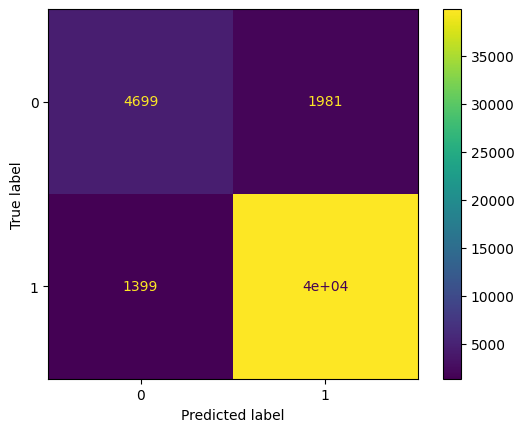

In [10]:
_ = ConfusionMatrixDisplay.from_estimator(best_clf, X_test['Review'], y_test)

Так, бейзлайн вспомнили, теперь попробуем его улучшить.

In [11]:
emoji = "👍"
data["cnt_ThumbsUp"] = data["Review"].apply(lambda x: x.count(emoji) + x.count("👍🏻"))

C:\Users\gfgh\AppData\Local\Temp\ipykernel_30004\3691456269.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["cnt_ThumbsUp"] = data["Review"].apply(lambda x: x.count(emoji) + x.count("👍🏻"))


In [12]:
print(data.sort_values(by="cnt_ThumbsUp", ascending=False))

                                                    Name  \
152456         Повербанк 40000 mah, пауэрбанк, powerbank   
132796                 Коврик для мышки Ковер персидский   
18041                          По ту сторону добра и зла   
178708  Слепок рук для двоих 3d парный подарок свадебный   
9538              Машинка металлическая моделька трамвай   
...                                                  ...   
66354                Сыворотка для роста ресниц и бровей   
66356                Сыворотка для роста ресниц и бровей   
66357                Сыворотка для роста ресниц и бровей   
66358                Сыворотка для роста ресниц и бровей   
196944         Звонок дверной беспроводной на батарейках   

                                              Description  \
152456  Power Bank 40000 mah - это универсальное заряд...   
132796  Коврик для мышки с рисунком персидского ковра....   
18041   "По ту сторону добра и зла"  важная этапная ра...   
178708  Только у нас набор в красив

Окак, кто-то реально написал отзыв с 389 эмодзи thumbs up, мы не можем на это не посмотреть подробнее.

In [13]:
print(data.sort_values(by="cnt_ThumbsUp", ascending=False)["Review"].iloc[0])

Банк супер! Доставили быстро, все супер! Доставили с зарядом 78%, заряжается быстро и заряжает телефон очень быстро. С 0% на телефоне за 30 минут зарядил примерно до 25%, даже больше. Мне нравится, продавца рекомендую 👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍❤️


Информативно. Чтож, а теперь посмотрим повлияет ли это хоть немного на результат.

In [14]:
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(data[['Review', "cnt_ThumbsUp"]],
                                                    data['Sentiment'],
                                                    stratify=data['Sentiment'],
                                                    test_size=0.25,
                                                    random_state=42)

X_train.shape, X_test.shape

((143769, 2), (47923, 2))

In [15]:
from sklearn.compose import ColumnTransformer

In [16]:
preprocessor = ColumnTransformer(
    transformers=[
        ('tf', TfidfVectorizer(), 'Review'),
        ('num', StandardScaler(), ['cnt_ThumbsUp'])
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(random_state=42))
])

param_grid = {
    'preprocessor__tf__ngram_range': [(1, 1), (1, 2), (1, 3)], # Важно посмотреть хотя бы на биграммах тоже
    'preprocessor__tf__max_features': [500, 1000, None],
    'clf__C': [0.1, 1, 10],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='precision', n_jobs=-1)

In [17]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('tf',
                                                                         TfidfVectorizer(),
                                                                         'Review'),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['cnt_ThumbsUp'])])),
                                       ('clf',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10],
                         'preprocessor__tf__max_features': [500, 1000, None],
                         'preprocessor__tf__ngram_range': [(1, 1), (1, 2),
                                                           (1, 3)]},
             scoring='precision')

In [18]:
print("Best parameters:", grid_search.best_params_)
best_clf = grid_search.best_estimator_
pred = best_clf.predict(X_test)
print(classification_report(y_test, pred))

Best parameters: {'clf__C': 10, 'preprocessor__tf__max_features': None, 'preprocessor__tf__ngram_range': (1, 3)}
              precision    recall  f1-score   support

           0       0.77      0.70      0.74      6680
           1       0.95      0.97      0.96     41243

    accuracy                           0.93     47923
   macro avg       0.86      0.84      0.85     47923
weighted avg       0.93      0.93      0.93     47923



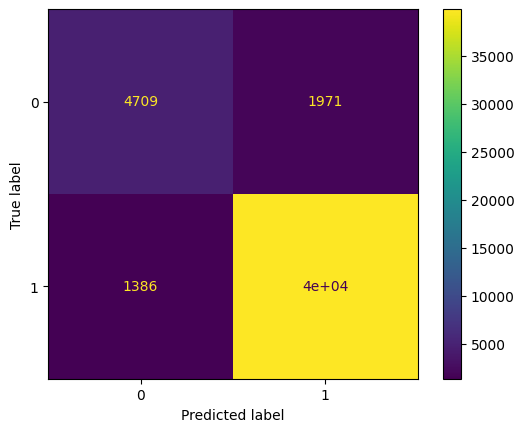

In [19]:
_ = ConfusionMatrixDisplay.from_estimator(best_clf, X_test, y_test)

Прирост оказался минимальным. Попробуем добавить еще каких-нибудь эмодзи и посмотреть, повлияет ли это на результат.

In [20]:
emoji = "❤️"
data["cnt_Heart"] = data["Review"].apply(lambda x: x.count(emoji))

C:\Users\gfgh\AppData\Local\Temp\ipykernel_30004\3409413954.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["cnt_Heart"] = data["Review"].apply(lambda x: x.count(emoji))


In [21]:
print(data.sort_values(by="cnt_Heart", ascending=False))

                                                     Name  \
71235   Сыворотка для лица увлажняющая с гиалуроновой ...   
160926  Пеленки для животных одноразовые на липучках 6...   
66076                 Сыворотка для роста ресниц и бровей   
87128             Деревянная кухня Уголок вкусных историй   
4601    Гель для душа женский и мужской парфюмированны...   
...                                                   ...   
64794           Высокие носки набор в подарочной упаковке   
64795           Высокие носки набор в подарочной упаковке   
64796           Высокие носки набор в подарочной упаковке   
64797           Высокие носки набор в подарочной упаковке   
196944          Звонок дверной беспроводной на батарейках   

                                              Description  \
71235   Увлажняющая сыворотка для лица с гиалуроновой ...   
160926  Одноразовые, гелевые пеленки для животных с ли...   
66076   Сыворотка для ресниц QUEENLASH Special Edition...   
87128   Деревянная кухн

In [22]:
emoji = "😍"
data["cnt_SmilingFaceWithHearts"] = data["Review"].apply(lambda x: x.count(emoji))

C:\Users\gfgh\AppData\Local\Temp\ipykernel_30004\701509331.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["cnt_SmilingFaceWithHearts"] = data["Review"].apply(lambda x: x.count(emoji))


In [23]:
print(data.sort_values(by="cnt_SmilingFaceWithHearts", ascending=False))

                                                     Name  \
10946   Наушники беспроводные с микрофоном A.Pods Andr...   
97201                  Энзимная пудра для умывания Пилинг   
146858  Silver Reflex Маска для волос от нежелательной...   
89726   Матрас 160х200 на кровать беспружинный ортопед...   
100708     Игровая приставка консоль для детей и взрослых   
...                                                   ...   
64765           Высокие носки набор в подарочной упаковке   
64766           Высокие носки набор в подарочной упаковке   
64767           Высокие носки набор в подарочной упаковке   
64768           Высокие носки набор в подарочной упаковке   
196944          Звонок дверной беспроводной на батарейках   

                                              Description  \
10946   Беспроводные наушники A.Pods 2 - это идеальное...   
97201   Профессиональная энзимная пудра для умывания л...   
146858  Kallos Маска Silver Reflex для нейтрализации ж...   
89726   Матрас на крова

In [24]:
X_train, X_test, y_train, y_test = train_test_split(data[['Review', "cnt_ThumbsUp", "cnt_SmilingFaceWithHearts", "cnt_Heart"]],
                                                    data['Sentiment'],
                                                    stratify=data['Sentiment'],
                                                    test_size=0.25,
                                                    random_state=42)

X_train.shape, X_test.shape

((143769, 4), (47923, 4))

In [25]:
preprocessor = ColumnTransformer(
    transformers=[
        ('tf', TfidfVectorizer(), 'Review'),
        ('num', StandardScaler(), ['cnt_ThumbsUp', 'cnt_SmilingFaceWithHearts', 'cnt_Heart'])
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(random_state=42))
])

param_grid = {
    'preprocessor__tf__ngram_range': [(1, 1), (1, 2), (1, 3)], 
    'preprocessor__tf__max_features': [500, 1000, None],
    'clf__C': [0.1, 1, 10],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='precision', n_jobs=-1)

In [26]:
grid_search.fit(X_train, y_train)

C:\Users\gfgh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('tf',
                                                                         TfidfVectorizer(),
                                                                         'Review'),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['cnt_ThumbsUp',
                                                                          'cnt_SmilingFaceWithHearts',
                                                                          'cnt_Heart'])])),
                                       ('clf',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10],
                         'preprocessor__tf__max_features': [500, 1000, None],
                         'preprocessor__tf__ngram_range': [(1, 1), (1, 2),
                                                           (1, 3)]},
             scoring='precision')

In [27]:
print("Best parameters:", grid_search.best_params_)
best_clf = grid_search.best_estimator_
pred = best_clf.predict(X_test)
print(classification_report(y_test, pred))

Best parameters: {'clf__C': 10, 'preprocessor__tf__max_features': None, 'preprocessor__tf__ngram_range': (1, 3)}
              precision    recall  f1-score   support

           0       0.77      0.71      0.74      6680
           1       0.95      0.97      0.96     41243

    accuracy                           0.93     47923
   macro avg       0.86      0.84      0.85     47923
weighted avg       0.93      0.93      0.93     47923



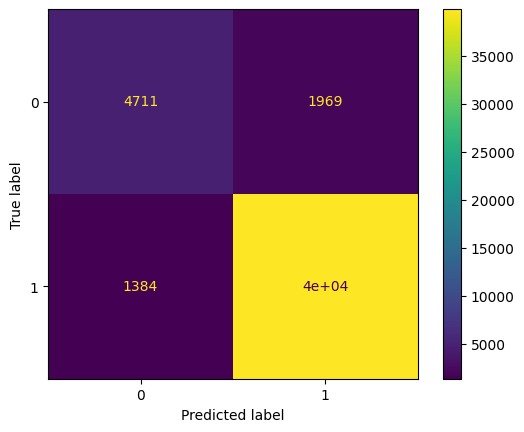

In [28]:
_ = ConfusionMatrixDisplay.from_estimator(best_clf, X_test, y_test)

Добавим еще акцент на фразы "не советую", "не рекомендую", которые явно указывают на негативность отзыва.

In [29]:
data["non_recommended"] = data["Review"].str.lower().apply(
    lambda x: "не советую" in x or "не рекомендую" in x
)

C:\Users\gfgh\AppData\Local\Temp\ipykernel_30004\9028852.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["non_recommended"] = data["Review"].str.lower().apply(


In [30]:
print(data.sort_values(by="non_recommended", ascending=False))

                                                     Name  \
114328  Комплект мужского термобелья: штаны и кофта дл...   
140976                                 Носки набор теплые   
185609    Ароматизатор для дома с палочками аромадиффузор   
5093    Гель для душа женский и мужской парфюмированны...   
57647    Мужской набор Captain дезодорант и гель для душа   
...                                                   ...   
65017   Скажи если сможешь, Попробуй произнести для ко...   
65018   Скажи если сможешь, Попробуй произнести для ко...   
65019   Скажи если сможешь, Попробуй произнести для ко...   
65020   Скажи если сможешь, Попробуй произнести для ко...   
196944          Звонок дверной беспроводной на батарейках   

                                              Description  \
114328  Представляем комплект мужского термобелья, нез...   
140976  Носки мужские теплые — это идеальное решение д...   
185609  Диффузор для дома Permegi — это стильный и эфф...   
5093    Парфюмированный

In [31]:
X_train, X_test, y_train, y_test = train_test_split(data[['Review', "cnt_ThumbsUp", "cnt_SmilingFaceWithHearts", "cnt_Heart", "non_recommended"]],
                                                    data['Sentiment'],
                                                    stratify=data['Sentiment'],
                                                    test_size=0.25,
                                                    random_state=42)

X_train.shape, X_test.shape

((143769, 5), (47923, 5))

In [32]:
preprocessor = ColumnTransformer(
    transformers=[
        ('tf', TfidfVectorizer(), 'Review'),
        ('num', StandardScaler(), ['cnt_ThumbsUp', 'cnt_SmilingFaceWithHearts', 'cnt_Heart']),
        ("bool", 'passthrough', ["non_recommended"])
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(random_state=42))
])

param_grid = {
    'preprocessor__tf__ngram_range': [(1, 1), (1, 2), (1, 3)], 
    'preprocessor__tf__max_features': [500, 1000, None],
    'clf__C': [0.1, 1, 10],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='precision', n_jobs=-1)

In [33]:
grid_search.fit(X_train, y_train)

C:\Users\gfgh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('tf',
                                                                         TfidfVectorizer(),
                                                                         'Review'),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['cnt_ThumbsUp',
                                                                          'cnt_SmilingFaceWithHearts',
                                                                          'cnt_Heart']),
                                                                        ('bool',
                                                                         'passthrough',
                                                                         ['non_recommended'])])),
                                       ('clf',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10],
                         'preprocessor__tf__max_features': [500, 1000, None],
                         'preprocessor__tf__ngram_range': [(1, 1), (1, 2),
                                                           (1, 3)]},
             scoring='precision')

In [34]:
print("Best parameters:", grid_search.best_params_)
best_clf = grid_search.best_estimator_
pred = best_clf.predict(X_test)
print(classification_report(y_test, pred))

Best parameters: {'clf__C': 10, 'preprocessor__tf__max_features': None, 'preprocessor__tf__ngram_range': (1, 3)}
              precision    recall  f1-score   support

           0       0.78      0.70      0.74      6680
           1       0.95      0.97      0.96     41243

    accuracy                           0.93     47923
   macro avg       0.86      0.83      0.85     47923
weighted avg       0.93      0.93      0.93     47923



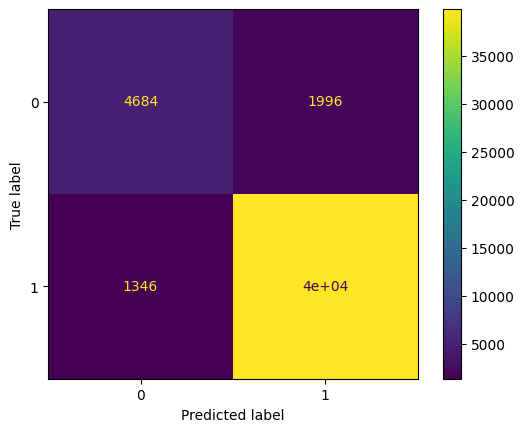

In [35]:
_ = ConfusionMatrixDisplay.from_estimator(best_clf, X_test, y_test)

Результат даже стали немного хуже. Попробуем еще немного поиграть с эмодзи, после чего перейдем к более перспективным подходам.

In [36]:
emoji = "🔥"
data["cnt_Fire"] = data["Review"].apply(lambda x: x.count(emoji))

C:\Users\gfgh\AppData\Local\Temp\ipykernel_30004\2845716338.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["cnt_Fire"] = data["Review"].apply(lambda x: x.count(emoji))


In [37]:
X_train, X_test, y_train, y_test = train_test_split(data[['Review', "cnt_ThumbsUp", "cnt_SmilingFaceWithHearts", "cnt_Heart", "cnt_Fire"]],
                                                    data['Sentiment'],
                                                    stratify=data['Sentiment'],
                                                    test_size=0.25,
                                                    random_state=42)

X_train.shape, X_test.shape

((143769, 5), (47923, 5))

In [38]:
preprocessor = ColumnTransformer(
    transformers=[
        ('tf', TfidfVectorizer(), 'Review'),
        ('num', StandardScaler(), ['cnt_ThumbsUp', 'cnt_SmilingFaceWithHearts', 'cnt_Heart', "cnt_Fire"])
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(random_state=42))
])

param_grid = {
    'preprocessor__tf__ngram_range': [(1, 1), (1, 2), (1, 3)], 
    'preprocessor__tf__max_features': [500, 1000, None],
    'clf__C': [0.1, 1, 10],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='precision', n_jobs=-1)

In [39]:
grid_search.fit(X_train, y_train)

C:\Users\gfgh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('tf',
                                                                         TfidfVectorizer(),
                                                                         'Review'),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['cnt_ThumbsUp',
                                                                          'cnt_SmilingFaceWithHearts',
                                                                          'cnt_Heart',
                                                                          'cnt_Fire'])])),
                                       ('clf',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10],
                         'preprocessor__tf__max_features': [500, 1000, None],
                         'preprocessor__tf__ngram_range': [(1, 1), (1, 2),
                                                           (1, 3)]},
             scoring='precision')

In [40]:
print("Best parameters:", grid_search.best_params_)
best_clf = grid_search.best_estimator_
pred = best_clf.predict(X_test)
print(classification_report(y_test, pred))

Best parameters: {'clf__C': 10, 'preprocessor__tf__max_features': None, 'preprocessor__tf__ngram_range': (1, 3)}
              precision    recall  f1-score   support

           0       0.78      0.71      0.74      6680
           1       0.95      0.97      0.96     41243

    accuracy                           0.93     47923
   macro avg       0.86      0.84      0.85     47923
weighted avg       0.93      0.93      0.93     47923



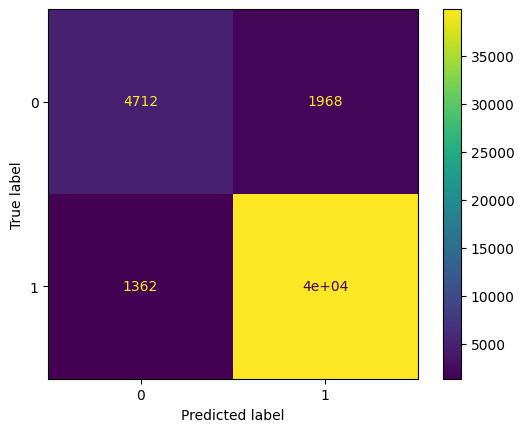

In [41]:
_ = ConfusionMatrixDisplay.from_estimator(best_clf, X_test, y_test)

Вновь получился крайне маленький прирост. Однако уже были рассмотрены более перспективные методы, поэтому было решено перейти к ним более приоритетной задачей.